In [49]:
import pandas as pd

def compute_iou(boxA, boxB):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.

    Parameters:
        boxA (dict): Dictionary containing 'x', 'y', 'width', 'height'.
        boxB (dict): Dictionary containing 'x', 'y', 'width', 'height'.

    Returns:
        float: IoU score between 0 and 1.
    """
    # Calculate coordinates of the intersection rectangle
    xA = max(boxA['x'], boxB['x'])
    yA = max(boxA['y'], boxB['y'])
    xB = min(boxA['x'] + boxA['width'], boxB['x'] + boxB['width'])
    yB = min(boxA['y'] + boxA['height'], boxB['y'] + boxB['height'])

    # Compute area of intersection rectangle
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    # Compute areas of both rectangles
    boxAArea = boxA['width'] * boxA['height']
    boxBArea = boxB['width'] * boxB['height']

    # Compute union area
    unionArea = boxAArea + boxBArea - interArea

    # Handle edge case where there is no overlap
    if unionArea == 0:
        return 0

    # Compute IoU
    return interArea / unionArea


def evaluate_aoi(detected_df, gt_df, iou_threshold=0.5):
    """
    Evaluate AOI detection performance by matching ground truth and detected tokens.

    Parameters:
        detected_df (pd.DataFrame): DataFrame containing detected tokens.
            Required columns: ['line_num', 'x', 'y', 'width', 'height', 'text'].
        gt_df (pd.DataFrame): DataFrame containing ground truth tokens.
            Required columns: ['line_num', 'x', 'y', 'width', 'height', 'text'].
        iou_threshold (float): Minimum IoU threshold for considering a match.

    Returns:
        dict: Performance metrics including TP, FP, FN, Precision, Recall, F1 Score, and Average IoU.
        list: List of matched pairs (index in gt_df, index in detected_df).
    """
    # Validate input columns
    required_columns = ['line_num', 'x', 'y', 'width', 'height', 'text']
    for df, name in [(gt_df, "ground truth"), (detected_df, "detected")]:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in {name} DataFrame: {missing_cols}")

    # Copy DataFrames to avoid modifying the originals
    gt_df = gt_df.copy()
    detected_df = detected_df.copy()

    # Initialize flags for matches
    gt_df['matched'] = False
    detected_df['matched'] = False

    # Lists to store results
    matches = []
    iou_scores = []

    # Iterate over each ground truth token
    for i, gt_row in gt_df.iterrows():
        best_match_idx = None
        best_iou = 0

        # Iterate over each detected token
        for j, det_row in detected_df.iterrows():
            # Skip already matched detections
            if det_row['matched']:
                continue

            # Check if line number and text match
            same_line = gt_row['line_num'] == det_row['line_num']
            same_text = gt_row['text'].strip().lower() == det_row['text'].strip().lower()

            if not (same_line and same_text):
                continue

            # Compute IoU
            iou = compute_iou(gt_row, det_row)

            # Update best match if current IoU is higher than previous best
            if iou >= iou_threshold and iou > best_iou:
                best_iou = iou
                best_match_idx = j

        # If a valid match is found, mark it as matched
        if best_match_idx is not None:
            gt_df.at[i, 'matched'] = True
            detected_df.at[best_match_idx, 'matched'] = True
            matches.append((i, best_match_idx))
            iou_scores.append(best_iou)

    # Compute performance metrics
    TP = len(matches)  # True Positives
    FP = len(detected_df) - TP  # False Positives
    FN = len(gt_df) - TP  # False Negatives

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

    # Prepare results dictionary
    results = {
        "True Positives": TP,
        "False Positives": FP,
        "False Negatives": FN,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Average IoU": avg_iou
    }

    return results, matches


# Example usage:
# Load your ground truth and detection results
gt_df = pd.read_csv("output/ocr_groundtruth/Q5_ground_truth03.csv")
detected_df = pd.read_csv("output/orc_detection/Q5_detected_tokens.csv")

# Ensure required columns are present
required_columns = ['line_num', 'x', 'y', 'width', 'height', 'text']
for df, name in [(gt_df, "Ground Truth"), (detected_df, "Detected")]:
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        print(f"Missing required columns in {name} DataFrame: {missing_cols}")
        exit(1)

# Evaluate AOI detection
results, matched_pairs = evaluate_aoi(detected_df, gt_df)

# Print evaluation results
print("==== AOI Detection Evaluation ====")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# Optionally, print matched pairs
print("\nMatched Pairs:")
for i, j in matched_pairs:
    print(f"GT Index: {i}, Detected Index: {j}")


==== AOI Detection Evaluation ====
True Positives: 77
False Positives: 72
False Negatives: 72
Precision: 0.5168
Recall: 0.5168
F1 Score: 0.5168
Average IoU: 1.0000

Matched Pairs:
GT Index: 72, Detected Index: 72
GT Index: 73, Detected Index: 73
GT Index: 74, Detected Index: 74
GT Index: 75, Detected Index: 75
GT Index: 76, Detected Index: 76
GT Index: 77, Detected Index: 77
GT Index: 78, Detected Index: 78
GT Index: 79, Detected Index: 79
GT Index: 80, Detected Index: 80
GT Index: 81, Detected Index: 81
GT Index: 82, Detected Index: 82
GT Index: 83, Detected Index: 83
GT Index: 84, Detected Index: 84
GT Index: 85, Detected Index: 85
GT Index: 86, Detected Index: 86
GT Index: 87, Detected Index: 87
GT Index: 88, Detected Index: 88
GT Index: 89, Detected Index: 89
GT Index: 90, Detected Index: 90
GT Index: 91, Detected Index: 91
GT Index: 92, Detected Index: 92
GT Index: 93, Detected Index: 93
GT Index: 94, Detected Index: 94
GT Index: 95, Detected Index: 95
GT Index: 96, Detected Index

In [60]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, distance
from collections import defaultdict
from typing import Tuple, Dict, List
import os

class OCREvaluator:
    def __init__(self, iou_threshold: float = 0.5, text_sim_threshold: float = 0.8):
        """
        Initialize the OCR evaluator with matching thresholds.
        
        Args:
            iou_threshold: Minimum IoU for bounding box matching (0-1)
            text_sim_threshold: Minimum text similarity ratio (0-1)
        """
        self.iou_threshold = iou_threshold
        self.text_sim_threshold = text_sim_threshold

    @staticmethod
    def compute_iou(box1: Dict, box2: Dict) -> float:
        """Calculate Intersection over Union for two bounding boxes"""
        x1 = max(box1['x'], box2['x'])
        y1 = max(box1['y'], box2['y'])
        x2 = min(box1['x'] + box1['width'], box2['x'] + box2['width'])
        y2 = min(box1['y'] + box1['height'], box2['y'] + box2['height'])

        inter_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area = box1['width'] * box1['height']
        box2_area = box2['width'] * box2['height']
        
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0
    
    @staticmethod
    def calculate_cer(gt_text: str, ocr_text: str) -> float:
        """Calculate Character Error Rate using Levenshtein distance"""
        if not gt_text:
            return 1.0 if ocr_text else 0.0

        if not ocr_text:
            return 1.0

        from rapidfuzz.distance import Levenshtein
        dist = Levenshtein.distance(gt_text, ocr_text)
        max_len = max(len(gt_text), len(ocr_text))
        return dist / max_len if max_len > 0 else 0

    @staticmethod
    def calculate_wer(gt_text: str, ocr_text: str) -> float:
        """Calculate Word Error Rate using Levenshtein distance on word lists"""
        gt_words = gt_text.split()
        ocr_words = ocr_text.split()

        if not gt_words:
            return 1.0 if ocr_words else 0.0

        if not ocr_words:
            return 1.0

        from rapidfuzz.distance import Levenshtein
        dist = Levenshtein.distance(gt_words, ocr_words)
        max_words = max(len(gt_words), len(ocr_words))
        return dist / max_words if max_words > 0 else 0


    def evaluate(
        self, 
        gt_df: pd.DataFrame, 
        detected_df: pd.DataFrame
    ) -> Tuple[Dict, List[Dict]]:
        """
        Perform comprehensive OCR evaluation.
        
        Args:
            gt_df: Ground truth DataFrame with columns:
                  ['line_num', 'x', 'y', 'width', 'height', 'text']
            detected_df: Detections DataFrame with columns:
                        ['line_num', 'x', 'y', 'width', 'height', 'text', 'confidence'] (confidence optional)
        
        Returns:
            Tuple containing:
            - metrics dictionary
            - list of matched pairs with details
        """
        self._validate_dataframes(gt_df, detected_df)
        
        metrics = {
            'character_level': {'cer': [], 'correct_chars': 0, 'total_chars': 0},
            'word_level': {'wer': [], 'correct_words': 0, 'total_words': 0},
            'detection': {'tp': 0, 'fp': 0, 'fn': 0, 'iou': []},
            'confidence': [] if 'confidence' in detected_df.columns else None
        }
        
        matched_pairs = []
        gt_matched = set()
        det_matched = set()
        
        # First pass: Strict matching
        for gt_idx, gt_row in gt_df.iterrows():
            best_match = None
            best_iou = 0
            best_sim = 0
            
            for det_idx, det_row in detected_df.iterrows():
                if det_idx in det_matched:
                    continue
                
                if gt_row['line_num'] != det_row['line_num']:
                    continue
                
                iou = self.compute_iou(gt_row, det_row)
                text_sim = fuzz.ratio(gt_row['text'], det_row['text']) / 100
                
                if (iou >= self.iou_threshold and 
                    text_sim >= self.text_sim_threshold and
                    (iou > best_iou or text_sim > best_sim)):
                    best_match = det_idx
                    best_iou = iou
                    best_sim = text_sim
            
            if best_match is not None:
                det_row = detected_df.loc[best_match]
                self._record_match(
                    gt_idx, best_match, gt_row, det_row, 
                    metrics, matched_pairs, gt_matched, det_matched
                )
        
        # Second pass: Relaxed matching for unmatched GT
        for gt_idx, gt_row in gt_df.iterrows():
            if gt_idx in gt_matched:
                continue
                
            best_match = None
            best_sim = 0
            
            for det_idx, det_row in detected_df.iterrows():
                if det_idx in det_matched:
                    continue
                
                text_sim = fuzz.ratio(gt_row['text'], det_row['text']) / 100
                if text_sim > best_sim:
                    best_sim = text_sim
                    best_match = det_idx
            
            if best_match is not None and best_sim >= self.text_sim_threshold * 0.5:
                det_row = detected_df.loc[best_match]
                self._record_match(
                    gt_idx, best_match, gt_row, det_row, 
                    metrics, matched_pairs, gt_matched, det_matched,
                    is_fuzzy=True
                )
        
        return self._calculate_final_metrics(metrics, len(gt_df)), matched_pairs

    def _validate_dataframes(self, gt_df: pd.DataFrame, detected_df: pd.DataFrame):
        """Validate input dataframes have required columns"""
        required_gt = ['line_num', 'x', 'y', 'width', 'height', 'text']
        required_det = ['line_num', 'x', 'y', 'width', 'height', 'text']
        
        missing_gt = [col for col in required_gt if col not in gt_df.columns]
        missing_det = [col for col in required_det if col not in detected_df.columns]
        
        if missing_gt:
            raise ValueError(f"Missing columns in ground truth: {missing_gt}")
        if missing_det:
            raise ValueError(f"Missing columns in detections: {missing_det}")

    def _record_match(
        self,
        gt_idx: int,
        det_idx: int,
        gt_row: pd.Series,
        det_row: pd.Series,
        metrics: Dict,
        matched_pairs: List[Dict],
        gt_matched: set,
        det_matched: set,
        is_fuzzy: bool = False
    ):
        """Record a matched pair and update metrics"""
        cer = self.calculate_cer(gt_row['text'], det_row['text'])
        wer = self.calculate_wer(gt_row['text'], det_row['text'])
        iou = self.compute_iou(gt_row, det_row)
        text_sim = fuzz.ratio(gt_row['text'], det_row['text']) / 100
        
        # Character-level
        gt_text_len = len(gt_row['text'])
        det_text_len = len(det_row['text'])
        correct_chars = gt_text_len - int(cer * max(gt_text_len, det_text_len))
        
        metrics['character_level']['cer'].append(cer)
        metrics['character_level']['correct_chars'] += correct_chars
        metrics['character_level']['total_chars'] += gt_text_len
        
        # Word-level
        gt_words = gt_row['text'].split()
        correct_words = len(gt_words) - int(wer * max(len(gt_words), len(det_row['text'].split())))
        
        metrics['word_level']['wer'].append(wer)
        metrics['word_level']['correct_words'] += correct_words
        metrics['word_level']['total_words'] += len(gt_words)
        
        # Detection
        metrics['detection']['tp'] += 1
        metrics['detection']['iou'].append(iou)
        
        if metrics['confidence'] is not None:
            metrics['confidence'].append(det_row.get('confidence', 0))
        
        matched_pairs.append({
            'gt_index': gt_idx,
            'det_index': det_idx,
            'gt_text': gt_row['text'],
            'det_text': det_row['text'],
            'cer': cer,
            'wer': wer,
            'iou': iou,
            'text_similarity': text_sim,
            'is_fuzzy': is_fuzzy
        })
        
        gt_matched.add(gt_idx)
        det_matched.add(det_idx)

    def _calculate_final_metrics(self, metrics: Dict, total_gt: int) -> Dict:
        """Calculate final aggregated metrics"""
        tp = metrics['detection']['tp']
        fp = len(metrics['detection']['iou']) - tp
        fn = total_gt - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        avg_cer = np.mean(metrics['character_level']['cer']) if metrics['character_level']['cer'] else 1.0
        char_accuracy = (metrics['character_level']['correct_chars'] / 
                        metrics['character_level']['total_chars']) if metrics['character_level']['total_chars'] > 0 else 0
        
        avg_wer = np.mean(metrics['word_level']['wer']) if metrics['word_level']['wer'] else 1.0
        word_accuracy = (metrics['word_level']['correct_words'] / 
                        metrics['word_level']['total_words']) if metrics['word_level']['total_words'] > 0 else 0
        
        avg_iou = np.mean(metrics['detection']['iou']) if metrics['detection']['iou'] else 0
        avg_conf = np.mean(metrics['confidence']) if metrics['confidence'] else None
        
        return {
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'character_error_rate': avg_cer,
            'character_accuracy': char_accuracy,
            'word_error_rate': avg_wer,
            'word_accuracy': word_accuracy,
            'average_iou': avg_iou,
            'average_confidence': avg_conf,
            'match_rate': tp / total_gt if total_gt > 0 else 0
        }

def print_metrics(metrics: Dict):
    """Print evaluation metrics in a readable format"""
    print("\nOCR Evaluation Results")
    print("=" * 60)
    print(f"{'Metric':<30} | {'Value':>12}")
    print("-" * 60)
    
    float_metrics = {
        'precision', 'recall', 'f1_score', 'character_error_rate',
        'character_accuracy', 'word_error_rate', 'word_accuracy',
        'average_iou', 'average_confidence', 'match_rate'
    }

    for metric, value in metrics.items():
        name = metric.replace('_', ' ').title()
        if metric in float_metrics:
            if value is not None:
                print(f"{name:<30} | {value:>12.4f}")
            else:
                print(f"{name:<30} | {'N/A':>12}")
        else:
            print(f"{name:<30} | {value:>12}")
    
    print("=" * 60)


def load_and_validate_csv(gt_path: str, det_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load and validate CSV files"""
    if not os.path.exists(gt_path):
        raise FileNotFoundError(f"Ground truth file not found: {gt_path}")
    if not os.path.exists(det_path):
        raise FileNotFoundError(f"Detection file not found: {det_path}")
    
    gt_df = pd.read_csv(gt_path)
    detected_df = pd.read_csv(det_path)
    
    # Basic validation
    required_cols = ['line_num', 'x', 'y', 'width', 'height', 'text']
    for df, name in [(gt_df, "Ground Truth"), (detected_df, "Detected")]:
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns in {name} CSV: {missing}")
    
    return gt_df, detected_df

def main():
    try:
        # Load your CSV files
        gt_path = "output/ocr_groundtruth/Q5_ground_truth03.csv"
        det_path = "output/orc_detection/Q5_detected_tokens.csv"
        
        print(f"Loading ground truth from: {gt_path}")
        print(f"Loading detections from: {det_path}")
        
        gt_df, detected_df = load_and_validate_csv(gt_path, det_path)
        
        print("\nData Summary:")
        print(f"Ground Truth entries: {len(gt_df)}")
        print(f"Detected entries: {len(detected_df)}")
        
        # Initialize evaluator with recommended thresholds
        evaluator = OCREvaluator(iou_threshold=0.3, text_sim_threshold=0.7)
        
        # Run evaluation
        print("\nEvaluating OCR performance...")
        metrics, matches = evaluator.evaluate(gt_df, detected_df)
        
        # Print results
        print_metrics(metrics)
        
        # Save detailed matches to CSV
        matches_df = pd.DataFrame(matches)
        output_path = "output/ocr_evaluation_results.csv"
        matches_df.to_csv(output_path, index=False)
        print(f"\nDetailed matches saved to: {output_path}")
        
    except Exception as e:
        print(f"\nError: {str(e)}")

if __name__ == "__main__":
    main()

Loading ground truth from: output/ocr_groundtruth/Q5_ground_truth03.csv
Loading detections from: output/orc_detection/Q5_detected_tokens.csv

Data Summary:
Ground Truth entries: 149
Detected entries: 149

Evaluating OCR performance...

OCR Evaluation Results
Metric                         |        Value
------------------------------------------------------------
True Positives                 |          149
False Positives                |            0
False Negatives                |            0
Precision                      |       1.0000
Recall                         |       1.0000
F1 Score                       |       1.0000
Character Error Rate           |       0.0000
Character Accuracy             |       1.0000
Word Error Rate                |       0.0000
Word Accuracy                  |       1.0000
Average Iou                    |       1.0000
Average Confidence             |          N/A
Match Rate                     |       1.0000

Detailed matches saved to: output/o

In [69]:
import pandas as pd
import Levenshtein
from rapidfuzz import fuzz
import os

def compute_cer_wer(gt_text: str, pred_text: str) -> dict:
    """Compute CER and WER between two full strings."""
    # CER
    ops = Levenshtein.editops(gt_text, pred_text)
    s = sum(1 for op in ops if op[0] == 'replace')
    i = sum(1 for op in ops if op[0] == 'insert')
    d = sum(1 for op in ops if op[0] == 'delete')
    n = len(gt_text)
    cer = (s + i + d) / n if n > 0 else 0

    # WER
    gt_words = gt_text.split()
    pred_words = pred_text.split()
    wer_dist = Levenshtein.distance(" ".join(gt_words), " ".join(pred_words))
    wer = wer_dist / max(len(gt_words), 1)

    return {
        'cer': cer,
        'wer': wer,
        'substitutions': s,
        'insertions': i,
        'deletions': d,
        'ground_truth_length': n
    }

# === Load CSVs ===
gt_path = "output/ocr_groundtruth/Q5_ground_truth04.csv"
det_path = "output/orc_detection/Q5_detected_tokens.csv"

gt_df = pd.read_csv(gt_path)
det_df = pd.read_csv(det_path)

# === Concatenate full text ===
gt_text_full = " ".join(gt_df['text'].astype(str).tolist()).strip()
det_text_full = " ".join(det_df['text'].astype(str).tolist()).strip()

# === Evaluate
metrics = compute_cer_wer(gt_text_full, det_text_full)

# === Output
print("==== Full Text OCR Evaluation ====")
print(f"Ground Truth Length: {metrics['ground_truth_length']}")
print(f"CER: {metrics['cer']:.4f}")
print(f"WER: {metrics['wer']:.4f}")
print(f"Substitutions: {metrics['substitutions']}")
print(f"Insertions: {metrics['insertions']}")
print(f"Deletions: {metrics['deletions']}")


==== Full Text OCR Evaluation ====
Ground Truth Length: 698
CER: 0.3582
WER: 2.2727
Substitutions: 15
Insertions: 220
Deletions: 15


In [66]:
print("=== Ground Truth Text ===")
print(gt_text_full)
print("\n=== Predicted Text ===")
print(det_text_full)


=== Ground Truth Text ===
Q: CHOOSE THE MOST ACCURATE ANSWER FOR THE FOLLOWING PROGRAM. Problem : A Strong Number is a positive integer whose sum of the factorials of its digits equals the original number. The program determines if an input value is a Strong Number. public static void main(String[] args) { : Scanner input=new Scanner (System. in) ; Expected Output : int sum = 0; a number: "); Enter a number: 145 int num = input.nextInt(); 5!1=120 Progressive sum int temp = num; 4!=24 Progressive sum while(temp != 0) { int factorial = 1; 1!=1 Progressive sum int digit = temp % 10; (digit + "!="); 145 is a strong number for(int i=digit;i>=1;1i--) { factorial=factorial*i; } System. + " "); sum = sum + factorial; System. out.print("\tProgressive sum = "+ "); System. out.printin(); num) .out.println(num + " is a strong number\n"); -out.println(num+ " is not a strong number\n"); sum%factorial temp%10 sum/factorial temp/10

=== Predicted Text ===
Q: CHOOSE THE MOST ACCURATE ANSWER FOR THE FOL

In [67]:
print(f"GT length: {len(gt_text_full)}")
print(f"Pred length: {len(det_text_full)}")
print(f"Identical? {gt_text_full == det_text_full}")


GT length: 903
Pred length: 903
Identical? True


🔶 1. Confusion Matrix (FTU vs Background)
This is only applicable if your task is binary pixel-level classification (e.g., FTU = foreground text unit, background = no text). For AOI evaluation, a token-level confusion matrix usually looks like this:

c:\Users\Administrator\miniconda3\envs\gazeseek\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

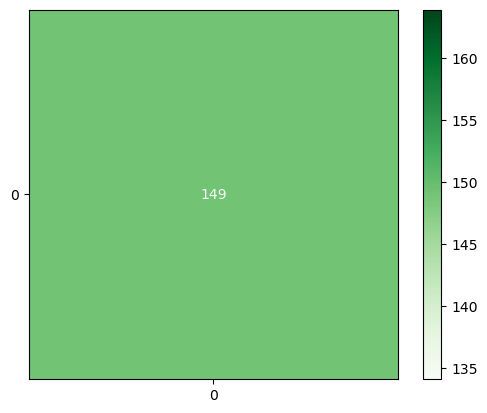

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create binary labels: 1 = matched (TP), 0 = unmatched (FP or FN)
gt_labels = [1] * len(gt_df)
det_labels = [1 if i in [j for _, j in matched_pairs] else 0 for i in range(len(detected_df))]

# Confusion matrix at token level
y_true = gt_labels + [0] * (len(detected_df) - len(matched_pairs))
y_pred = [1] * len(matched_pairs) + [0] * (len(detected_df) - len(matched_pairs))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "FTU"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix (Token-Level)")
plt.show()



🔷 2. IoU vs DICE Comparison Plot
If you want to compare IoU and Dice coefficient over different intersection sizes, here’s how to recreate the second figure:

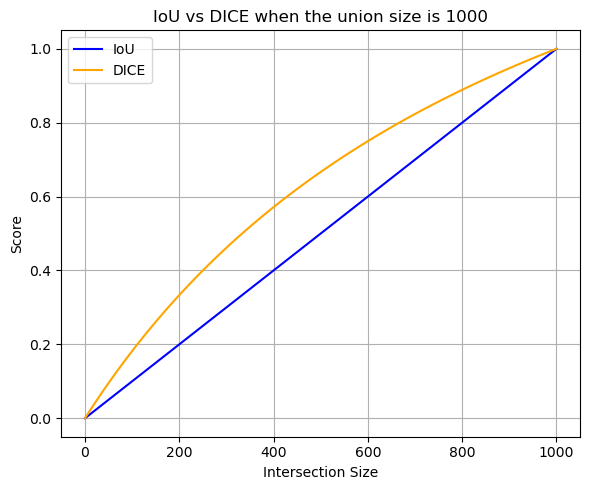

In [45]:
import numpy as np
import matplotlib.pyplot as plt

union_size = 1000
intersection_sizes = np.arange(0, union_size + 1, 10)
iou_scores = intersection_sizes / union_size
dice_scores = 2 * intersection_sizes / (union_size + intersection_sizes)

plt.figure(figsize=(6, 5))
plt.plot(intersection_sizes, iou_scores, label='IoU', color='blue')
plt.plot(intersection_sizes, dice_scores, label='DICE', color='orange')
plt.xlabel("Intersection Size")
plt.ylabel("Score")
plt.title("IoU vs DICE when the union size is 1000")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔶 3. ROC Curve with AUC (for token-level match detection)
To generate an ROC curve, you need a score per detected token (e.g., OCR confidence, IoU), and a binary label (1 = match, 0 = not match):

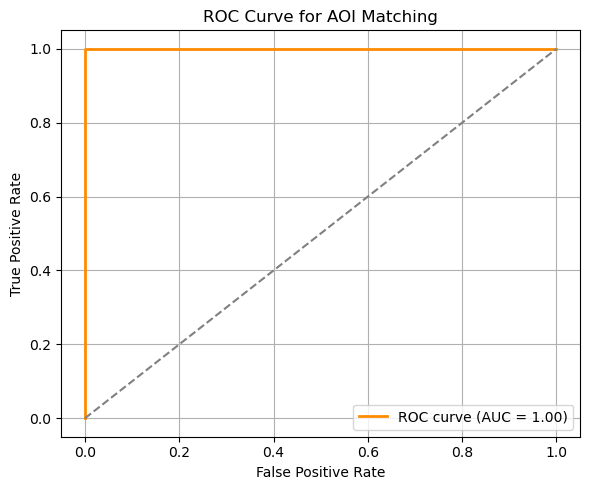

In [46]:
from sklearn.metrics import roc_curve, auc

# Example: IoU score per detected token
# If token matched: use IoU, else 0
detected_scores = []
labels = []

for i, row in detected_df.iterrows():
    match_found = False
    for gt_idx, det_idx in matched_pairs:
        if det_idx == i:
            iou_val = compute_iou(gt_df.loc[gt_idx], detected_df.loc[det_idx])
            detected_scores.append(iou_val)
            labels.append(1)
            match_found = True
            break
    if not match_found:
        detected_scores.append(0)
        labels.append(0)

# Compute ROC
fpr, tpr, thresholds = roc_curve(labels, detected_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AOI Matching")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


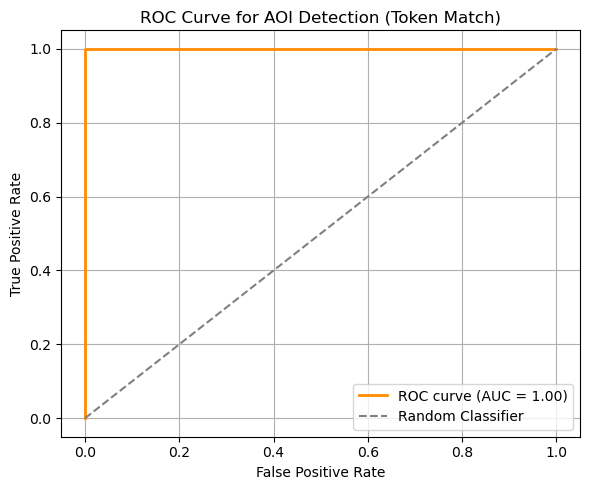

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(detected_df, gt_df, matched_pairs, iou_threshold=0.5):
    """
    Plot ROC curve using IoU as the score for detected tokens.
    """
    y_true = []
    y_scores = []

    matched_detected_ids = {j for _, j in matched_pairs}

    for i, det in detected_df.iterrows():
        is_matched = i in matched_detected_ids
        y_true.append(1 if is_matched else 0)

        # Score: use IoU if matched, else 0
        score = 0
        for gt_idx, det_idx in matched_pairs:
            if det_idx == i:
                score = compute_iou(gt_df.loc[gt_idx], detected_df.loc[det_idx])
                break
        y_scores.append(score)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for AOI Detection (Token Match)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run ROC plot
plot_roc_curve(detected_df, gt_df, matched_pairs)
